# SMAC Search for Vision

In [1]:
from toolbox import *
import warnings
import argparse
import random
import os
import pandas as pd
import numpy as np
import cv2
import librosa
import time
import re
from timeout_decorator import timeout
import json

import matplotlib.pyplot as plt
import numpy as np
from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    EqualsCondition,
    Float,
    InCondition,
    Integer,
)

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import cohen_kappa_score, accuracy_score
import xgboost as xgb

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from skopt.callbacks import DeadlineStopper

from smac import MultiFidelityFacade as MFFacade
from smac import Scenario
from smac.facade import AbstractFacade
from smac.intensifier.hyperband import Hyperband
from smac.intensifier.successive_halving import SuccessiveHalving

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
import torchaudio
import torchaudio.transforms as trans
import re

from line_profiler import LineProfiler
from pathlib import Path


warnings.filterwarnings("ignore", category=RuntimeWarning)

/home/ziyan/miniconda3/envs/NeuroData/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ziyan/miniconda3/envs/NeuroData/lib/python3.9/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [3]:
def combinations_45(iterable, r):
    """Extracts 45 combinations from given list"""
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    count = 0
    while count < 44:
        count += 1
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i + 1, r):
            indices[j] = indices[j - 1] + 1
        yield tuple(pool[i] for i in indices)

torch.multiprocessing.freeze_support()
n_classes = 3 # number of classes
samples_space = np.geomspace(10, 9000, num=8, dtype=int)
nums = list(range(10))
random.shuffle(nums)
classes_space = list(combinations_45(nums, n_classes))
normalize = lambda x: x / 255.0

cifar_trainset = datasets.CIFAR10(
    root="./", train=True, download=True, transform=None
)
cifar_train_images = normalize(cifar_trainset.data)
cifar_train_labels = np.array(cifar_trainset.targets)

cifar_testset = datasets.CIFAR10(
    root="./", train=False, download=True, transform=None
)
cifar_test_images = normalize(cifar_testset.data)
cifar_test_labels = np.array(cifar_testset.targets)

# cifar_train_images = cifar_train_images.reshape(-1, 32 * 32 * 3)
# cifar_test_images = cifar_test_images.reshape(-1, 32 * 32 * 3)

images = np.concatenate((cifar_train_images, cifar_test_images))
labels = np.concatenate((cifar_train_labels, cifar_test_labels))

indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

train_images, test_valid_images, train_labels, test_valid_labels = train_test_split(
    images, labels, test_size=0.5, random_state=317
)

test_images, valid_images, test_labels, valid_labels = train_test_split(
    test_valid_images, test_valid_labels, test_size=0.5, random_state=317
)

train_x = train_images
train_y = train_labels
test_x = test_images
test_y = test_labels
valid_x = valid_images
valid_y = valid_labels
test_valid_x = test_valid_images
test_valid_y = test_valid_labels

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# print(len(classes_space[0]))

In [5]:
class SimpleCNN32Filter(nn.Module):
    """
    Defines a simple CNN arhcitecture with 1 layer
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=10, stride=2)
        self.fc1 = nn.Linear(12 * 12 * 32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144 * 32)
        x = self.fc1(x)
        return x


class SimpleCNN32Filter2Layers(nn.Module):
    """
    Define a simple CNN arhcitecture with 2 layers
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(12 * 12 * 32, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class SimpleCNN32Filter5Layers(nn.Module):
    """
    Define a simple CNN arhcitecture with 5 layers
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(12 * 12 * 128, 200)
        self.fc2 = nn.Linear(200, num_classes)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.bn = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn(self.conv2(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.relu(self.bn3(self.conv5(x)))
        x = self.maxpool(x)
        x = x.view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SimpleCNN32Filter10Layers(nn.Module):
    """
    Define a simple CNN arhcitecture with 10 layers
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(12 * 12 * 512, 200)
        self.fc2 = nn.Linear(200, num_classes)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.bn = BatchNorm2d(32)
        self.bn2 = BatchNorm2d(64)
        self.bn3 = BatchNorm2d(128)
        self.bn4 = BatchNorm2d(256)
        self.bn5 = BatchNorm2d(512)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn(self.conv2(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.bn3(self.conv6(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn4(self.conv7(x)))
        x = F.relu(self.bn4(self.conv8(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn5(self.conv9(x)))
        x = F.relu(self.bn5(self.conv10(x)))
        x = self.maxpool(x)
        x = x.view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# CNN architectures
cnn32 = SimpleCNN32Filter(10)
cnn32_2l = SimpleCNN32Filter2Layers(10)
cnn32_5l = SimpleCNN32Filter5Layers(10)

# Resnet
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

# EfficientNet
# efnet = models.efficientnet_b0(pretrained=True)
# num_classes = 10
# efnet.classifier[1] = nn.Linear(efnet.classifier[1].in_features, num_classes)

# XGBT tuning

In [9]:
class XGBWrapper(BaseEstimator):
    def __init__(self, n_estimators=100, max_depth=2, seed= 317, min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.5, learning_rate=0.1, objective='multi:softprob', colsample_bylevel=0.5, colsample_bynode=0.5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.seed= seed
        self.min_child_weight = min_child_weight
        self.gamma = gamma
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.colsample_bylevel = colsample_bylevel
        self.colsample_bynode = colsample_bynode
        self.learning_rate = learning_rate
        self.objective = objective
        self.model = xgb.XGBClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, seed=self.seed, min_child_weight=self.min_child_weight, gamma=self.gamma, subsample=self.subsample, colsample_bytree=self.colsample_bytree, colsample_bylevel=self.colsample_bylevel, colsample_bynode=self.colsample_bynode ,learning_rate=self.learning_rate, objective=self.objective)

    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()
        n_estimators = Integer("n_estimators", (100, 1200), default=100)
        max_depth = Integer("max_depth", (2, 21), default=2)
        min_child_weight = Integer("min_child_weight", (1, 10), default=1)
        gamma = Float("gamma", (0.1, 1.0), default=0.1)
        subsample = Float("subsample", (0.5, 1.0), default=0.8)
        colsample_bytree = Float("colsample_bytree", (0.3, 1.0), default=0.6)
        colsample_bylevel = Float("colsample_bylevel", (0.3, 1.0), default=0.6)
        colsample_bynode = Float("colsample_bynode", (0.3, 1.0), default=0.6)
        learning_rate = Float("learning_rate", (0.001, 0.3), default=0.1)
        cs.add_hyperparameters([n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, learning_rate])
        return cs
    
    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        config = dict(config)  
        self.model.set_params(**config)
        X = train_x
        y = train_y
        X = X.reshape(X.shape[0], -1)
        
        scores = cross_val_score(self.model, X, y, cv=5)
        return 1 - np.mean(scores)
    

def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)


    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()
        

In [10]:
@timeout(21600)
def main():
    GBT = XGBWrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:

        scenario = Scenario(
            GBT.configspace,
            walltime_limit=21600,
            output_directory=Path("smac_hyperband_output_budget_6hr_XGBT"),
            n_trials=10000,
            min_budget=100,
            max_budget=1000,
            n_workers=1,

        )

        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")

        smac = MFFacade(
            scenario,
            GBT.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )

        print("optimiizing")
        print(type(smac), "|", smac)
        incumbent = smac.optimize()
        print("incumbent:", incumbent)
        default_cost = smac.validate(GBT.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")

        facades.append(smac)
        for arrt in dir(smac):
            if not arrt.startswith("_"):
                print(arrt, getattr(smac, arrt))

    print("facades:", facades)
    BO_file = None
    plot_trajectory(facades, BO_file)


if __name__ == "__main__":
    # with open('smac_results_2h.txt', "w") as f:
    #     pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimiizing
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fde384d8a60>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 2: [1000.0]


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7fde60d4f5e0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/xgboost/core.py", line 588, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


# RF tuning

In [19]:
class RFWrapper(BaseEstimator):
    def __init__(self, n_estimators=100, max_depth=2, random_state=317, min_samples_split=2, min_samples_leaf=1, max_features=None, criterion="gini", max_samples = 0.5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features   
        self.criterion = "gini"
        self.max_samples = max_samples
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, random_state=self.random_state, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, criterion=self.criterion, max_features=self.max_features, max_samples=self.max_samples)

    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()
        n_estimators = Integer("n_estimators", (100, 1200), default=100)
        max_depth = Integer("max_depth", (2,21), default=2)
        min_samples_split = Integer("min_samples_split", (2, 20), default=2)
        min_samples_leaf = Integer("min_samples_leaf", (1, 20), default=1)
        criterion = Categorical("criterion", ["gini", "entropy", "log_loss"], default="gini")
        max_features = Categorical("max_features", ["sqrt", "log2", "None"], default="None")
        max_samples = Float("max_samples", (0.1, 0.99), log=True)
        cs.add_hyperparameters([n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion, max_features, max_samples])
        return cs
    
    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        config = dict(config)  
        if config['max_features'] == 'None':
            config['max_features'] = None
        self.model.set_params(**config)
        X = train_x
        y = train_y
        X = X.reshape(X.shape[0], -1)
        
        scores = cross_val_score(self.model, X, y, cv=5)
        return 1 - np.mean(scores)
    

def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)


    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()
        

In [20]:
@timeout(21600)
def main():
    RF = RFWrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:

        scenario = Scenario(
            RF.configspace,
            walltime_limit=21600,
            output_directory=Path("smac_hyperband_output_budget_6hr_RF"),
            n_trials=10000,
            min_budget=100,
            max_budget=1000,
            n_workers=4,

        )

        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")

        smac = MFFacade(
            scenario,
            RF.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )

        print("optimiizing")
        print(type(smac), "|", smac)
        incumbent = smac.optimize()
        print("incumbent:", incumbent)
        default_cost = smac.validate(RF.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")

        facades.append(smac)
        for arrt in dir(smac):
            if not arrt.startswith("_"):
                print(arrt, getattr(smac, arrt))

    print("facades:", facades)
    BO_file = None
    plot_trajectory(facades, BO_file)


if __name__ == "__main__":
    # with open('smac_results_2h.txt', "w") as f:
    #     pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

    

[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimiizing
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fd7a7968bb0>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 2:

2024-05-13 12:57:35,646 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('run_wrapper-a726a74b6ad0ee991dafee5753b67103')" coro=<Worker.execute() done, defined at /opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-05-13 12:57:35,646 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('run_wrapper-f2d2d565ae9bc191807118b67db89710')" coro=<Worker.execute() done, defined at /opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-05-13 12:57:35,646 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('run_wrapper-42624ed233b4b634f44ec876e1aeee14')" coro=<Worker.execute() done, defined at /opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/distributed/worker_state_machine.py:3615>> ended wit

KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
2024-05-13 12:57:37,860 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-05-13 12:57:37,862 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-05-13 12:57:37,866 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/opt/anaconda3/envs/NeuroData/lib/python3.9/site-packages/distributed/nanny.py", line 1014, in _run
    asyncio_run(run(), loop_factor

# DN tuning

In [9]:
# train_tensor = torch.tensor(train_images, dtype=torch.float32)
# train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
# test_tensor = torch.tensor(test_images, dtype=torch.float32)
# test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
# valid_tensor = torch.tensor(valid_images, dtype=torch.float32)
# valid_labels_tensor = torch.tensor(valid_labels, dtype=torch.long)

# train_dataset = torch.utils.data.TensorDataset(train_tensor, train_labels_tensor)
# test_dataset = torch.utils.data.TensorDataset(test_tensor, test_labels_tensor)
# valid_dataset = torch.utils.data.TensorDataset(valid_tensor, valid_labels_tensor)

# train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=4)
# valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=False, num_workers=4)

In [8]:
# For CNN 
data_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

In [10]:
class CNN32Wrapper(BaseEstimator):
    def __init__(self, criterion = nn.CrossEntropyLoss()):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = cnn32.to(self.device)
        self.criterion = criterion
        self.lr = None
        self.batch_size = None
        self.epochs = None
        self.optimizer = None

    @property
    def configspace(self)-> ConfigurationSpace:
        cs = ConfigurationSpace()
        lr_init = Float("lr_init", (0.00001, 0.1), log=True)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        solver = Categorical("solver", ["sgd", "adam"])
        batch_size = Integer("batch_size", (16, 1024))
        epochs = Integer("epochs", (30, 160))
        cs.add_hyperparameters([lr_init, learning_rate, solver, batch_size, epochs])

        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        cs.add_conditions([use_lr])

        weight_decay = Float("weight_decay", (0.0001, 0.1), log=True)
        momentum = Float("momentum", (0, 0.99))
        dampening = Float("dampening", (0, 0.99))
        cs.add_hyperparameters([weight_decay, momentum, dampening])

        weight_decay_condition = InCondition(child=weight_decay, parent=solver, values=["sgd", "adam"])
        momentum_condition = InCondition(child=momentum, parent=solver, values=["sgd"])
        dampening_condition = InCondition(child=dampening, parent=solver, values=["sgd"])
        cs.add_conditions([use_lr, weight_decay_condition, momentum_condition, dampening_condition])

        return cs
    
    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        self.trial_start_time = time.perf_counter()

        print("Config:", config)
        # print(time.time())
        epoch_start_timer = time.perf_counter()
        # print("okay here?")
        max_epochs = [0]
        # print("what abt here?")

        X = torch.tensor(train_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        y = torch.tensor(train_y, dtype=torch.long)
        valid_x_inFit = torch.tensor(valid_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        valid_y_inFit = torch.tensor(valid_y, dtype=torch.long)


        # ### only for resnet:
        # X = X.repeat(1, 3, 1, 1)
        # valid_x_inFit = valid_x_inFit.repeat(1, 3, 1, 1)


        # print("so far so good")
        # print("Model:", self.model)
        model = self.model
        # print("break1")
        # print("Criterion:", self.criterion)
        criterion = self.criterion

        self.lr = config.get('lr_init')
        # print("lr:", self.lr)
        self.epochs = config.get('epochs')
        # print("epochs:", self.epochs)
        self.batch_size = config.get('batch_size')
        # print("batch_size:", self.batch_size)
        # print("solver type:", type(self.sovler))
        solver_name = config.get('solver', 'sgd')
        # print("solver_name:", solver_name, type(solver_name))
        momentum = config.get('momentum', 0.9)
        weight_decay = config.get('weight_decay', 0.9)
        dampening = config.get('dampening', 0.9)
        print("is sgd:", solver_name=='sgd', "| is adam:", solver_name=='adam')
        # print(self.model.parameters())
        if solver_name == 'sgd':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'momentum': config.get('momentum', 0),
            #     'weight_decay': config.get('weight_decay', 0),
            #     'dampening': config.get('dampening', 0)
            # }
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)

        elif solver_name == 'adam':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'weight_decay': config.get('weight_decay', 0) 
            # }
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)

        else:
            raise ValueError(f"Unknown optimizer: {solver_name}")
        # print("solver type:", type(self.optimizer))
        # print("solver:", self.optimizer)
        prev_loss = float("inf")
        flag = 0

        for epoch in range(self.epochs):
            model.train()
            for i in range(0, len(X), self.batch_size):
                # print(type(X), type(y))
                inputs = X[i : i + self.batch_size].to(self.device)
                labels = y[i : i + self.batch_size].to(self.device)
                self.optimizer.zero_grad()
                if inputs.shape[0] <= 2:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

            model.eval()
            cur_loss = 0
            with torch.no_grad():
                for i in range(0, len(valid_x_inFit), self.batch_size):
                    # get the inputs
                    inputs = valid_x_inFit[i : i + self.batch_size].to(self.device)
                    labels = valid_y_inFit[i : i + self.batch_size].to(self.device)
                    if inputs.shape[0] == 1:
                        inputs = torch.cat((inputs, inputs, inputs), dim = 0)
                        labels = torch.cat((labels, labels, labels), dim = 0)

                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss
            # early stop if 3 epochs in a row no loss decrease
            # print(round(time.time()-epoch_start_timer, 2))
            # if time.perf_counter() - epoch_start_timer > budget:
            #     print(f"Stopping training early at epoch {epoch} due to time budget.")
            #     break  # Stop training if budget exceeded
            
            if cur_loss < prev_loss:
                prev_loss = cur_loss
                flag = 0
            else:
                flag += 1
                if flag >= 3:
                    max_epochs.append(epoch)
                    break

        # print(np.max(max_epochs))
        print("evaluating...")
        model.eval()
        with torch.no_grad():
            outputs = model(valid_x_inFit.to(self.device))
            _, predicted = torch.max(outputs.data, 1)
            predictions = predicted.cpu().numpy()
        acc = accuracy_score(valid_y, predictions)
        print("accuracy:", acc)

        self.trial_end_time = time.perf_counter()
        valid_probs = self.predict_proba(valid_x_inFit)
        valid_kappa = cohen_kappa_score(valid_y, predictions)
        valid_ece = get_ece(valid_probs, predictions, valid_y)
        with open('smac_results_2h.txt', "a") as f:
            f.write(f"Valid Accuracy: {acc}, Valid Kappa: {valid_kappa}, Valid ECE: {valid_ece}, Time: {self.trial_end_time - self.trial_start_time}\n")
            
        return 1-acc
    
    def predict_proba(self, X):
        # X = X.reshape(-1, 3, 32, 32)
        model = self.model
        model.eval()
        test_probs = []
        with torch.no_grad():
            outputs = model(X.to(self.device))
            test_prob = nn.Softmax(dim=1)(outputs)
            test_probs = test_prob.cpu().numpy()
            return test_probs
        
def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)
    # print("\nfacades[1]:", facades[1].scenario)
    # plt.ylim(0, 0.4)

    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()



[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimizing...
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fd7a7994250>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 2: [1000.0]
[INFO][smbo.py:319] Finished 0 trials.
Config: Configuration(values={
  'batch_size': 569

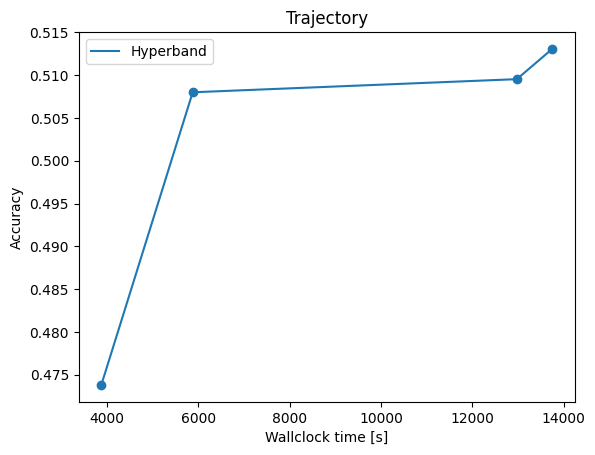

Timer unit: 1e-09 s

Total time: 15028.1 s
File: /var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_43860/1149617428.py
Function: main at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def main():
     5                                           
     6                                               
     7         1    1634000.0    2e+06      0.0      CNN32 = CNN32Wrapper()
     8                                           
     9         1          0.0      0.0      0.0      facades: list[AbstractFacade] = []
    10         2       7000.0   3500.0      0.0      for intensifier_object in [Hyperband]:
    11                                                   # Define our environment variables
    12                                                   
    13         2      24000.0  12000.0      0.0          scenario = Scenario(
    14         1    5712000.0    6e+06      0.0              CNN32.configspace,
    

In [11]:
from line_profiler import LineProfiler
from pathlib import Path
# @timeout(14400)
def main():

    
    CNN32 = CNN32Wrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:
        # Define our environment variables
        
        scenario = Scenario(
            CNN32.configspace,
            walltime_limit=21600,  # After 3600 seconds, we stop the hyperparameter optimization
            output_directory=Path("smac_hyperband_output_budget_6hr_CNN_1l"),
            n_trials=10000,  # Evaluate max 500 different trials
            min_budget=100,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
            # max_budget=25,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
            max_budget=1000,  # only for CNN32_5layers, Resnet18
            n_workers=2,
        )


        
        # We want to run five random configurations before starting the optimization.
        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        
        # Create our intensifier
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")
        
        # Create our SMAC object and pass the scenario and the train method
        smac = MFFacade(
            scenario,
            CNN32.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )
        # print("I fitted!!!!!!!!!!!!!!:", smac)

        # Let's optimize
        print("optimizing...")
        print(type(smac), "|", smac)
        opt_start_time = time.time()
        incumbent = smac.optimize()
        opt_end_time = time.time()
        print(f"opt execution time: {opt_end_time - opt_start_time} seconds")
        print("incumbent:", incumbent)
        # break
        # Get cost of default configuration
        default_cost = smac.validate(CNN32.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")

        # Let's calculate the cost of the incumbent
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")
        print("appending...")
        facades.append(smac)
        for attr in dir(smac):
            if not attr.startswith('__'):
                print(attr, getattr(smac, attr))
    print("attempting to plot")
    # Let's plot it
    print("facades:", facades)
    # BO_file = "CNN32_5l_BO_results_2h.txt"
    plot_trajectory(facades)

if __name__ == "__main__":
    with open('smac_results_2h.txt', "w") as f:
        pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

In [12]:
class CNN32Wrapper(BaseEstimator):
    def __init__(self, criterion = nn.CrossEntropyLoss()):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = cnn32_2l.to(self.device)
        self.criterion = criterion
        self.lr = None
        self.batch_size = None
        self.epochs = None
        self.optimizer = None

    @property
    def configspace(self)-> ConfigurationSpace:
        cs = ConfigurationSpace()
        lr_init = Float("lr_init", (0.00001, 0.1), log=True)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        solver = Categorical("solver", ["sgd", "adam"])
        batch_size = Integer("batch_size", (16, 1024))
        epochs = Integer("epochs", (30, 160))
        cs.add_hyperparameters([lr_init, learning_rate, solver, batch_size, epochs])

        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        cs.add_conditions([use_lr])

        weight_decay = Float("weight_decay", (0.0001, 0.1), log=True)
        momentum = Float("momentum", (0, 0.99))
        dampening = Float("dampening", (0, 0.99))
        cs.add_hyperparameters([weight_decay, momentum, dampening])

        weight_decay_condition = InCondition(child=weight_decay, parent=solver, values=["sgd", "adam"])
        momentum_condition = InCondition(child=momentum, parent=solver, values=["sgd"])
        dampening_condition = InCondition(child=dampening, parent=solver, values=["sgd"])
        cs.add_conditions([use_lr, weight_decay_condition, momentum_condition, dampening_condition])

        return cs
    
    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        self.trial_start_time = time.perf_counter()

        print("Config:", config)
        # print(time.time())
        epoch_start_timer = time.perf_counter()
        # print("okay here?")
        max_epochs = [0]
        # print("what abt here?")

        X = torch.tensor(train_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        y = torch.tensor(train_y, dtype=torch.long)
        valid_x_inFit = torch.tensor(valid_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        valid_y_inFit = torch.tensor(valid_y, dtype=torch.long)


        # print("so far so good")
        # print("Model:", self.model)
        model = self.model
        # print("break1")
        # print("Criterion:", self.criterion)
        criterion = self.criterion

        self.lr = config.get('lr_init')
        # print("lr:", self.lr)
        self.epochs = config.get('epochs')
        # print("epochs:", self.epochs)
        self.batch_size = config.get('batch_size')
        # print("batch_size:", self.batch_size)
        # print("solver type:", type(self.sovler))
        solver_name = config.get('solver', 'sgd')
        # print("solver_name:", solver_name, type(solver_name))
        momentum = config.get('momentum', 0.9)
        weight_decay = config.get('weight_decay', 0.9)
        dampening = config.get('dampening', 0.9)
        print("is sgd:", solver_name=='sgd', "| is adam:", solver_name=='adam')
        # print(self.model.parameters())
        if solver_name == 'sgd':
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)

        elif solver_name == 'adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)

        else:
            raise ValueError(f"Unknown optimizer: {solver_name}")
        prev_loss = float("inf")
        flag = 0

        for epoch in range(self.epochs):
            model.train()
            for i in range(0, len(X), self.batch_size):
                # print(type(X), type(y))
                inputs = X[i : i + self.batch_size].to(self.device)
                labels = y[i : i + self.batch_size].to(self.device)
                self.optimizer.zero_grad()
                if inputs.shape[0] <= 2:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

            model.eval()
            cur_loss = 0
            with torch.no_grad():
                for i in range(0, len(valid_x_inFit), self.batch_size):
                    # get the inputs
                    inputs = valid_x_inFit[i : i + self.batch_size].to(self.device)
                    labels = valid_y_inFit[i : i + self.batch_size].to(self.device)
                    if inputs.shape[0] == 1:
                        inputs = torch.cat((inputs, inputs, inputs), dim = 0)
                        labels = torch.cat((labels, labels, labels), dim = 0)

                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss
            
            if cur_loss < prev_loss:
                prev_loss = cur_loss
                flag = 0
            else:
                flag += 1
                if flag >= 3:
                    max_epochs.append(epoch)
                    break

        # print(np.max(max_epochs))
        print("evaluating...")
        model.eval()
        with torch.no_grad():
            outputs = model(valid_x_inFit.to(self.device))
            _, predicted = torch.max(outputs.data, 1)
            predictions = predicted.cpu().numpy()
        acc = accuracy_score(valid_y, predictions)
        print("accuracy:", acc)

        self.trial_end_time = time.perf_counter()
        valid_probs = self.predict_proba(valid_x_inFit)
        valid_kappa = cohen_kappa_score(valid_y, predictions)
        valid_ece = get_ece(valid_probs, predictions, valid_y)
        with open('smac_results_2h.txt', "a") as f:
            f.write(f"Valid Accuracy: {acc}, Valid Kappa: {valid_kappa}, Valid ECE: {valid_ece}, Time: {self.trial_end_time - self.trial_start_time}\n")
            
        return 1-acc
    
    def predict_proba(self, X):
        # X = X.reshape(-1, 3, 32, 32)
        model = self.model
        model.eval()
        test_probs = []
        with torch.no_grad():
            outputs = model(X.to(self.device))
            test_prob = nn.Softmax(dim=1)(outputs)
            test_probs = test_prob.cpu().numpy()
            return test_probs
        
def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)
    # print("\nfacades[1]:", facades[1].scenario)
    # plt.ylim(0, 0.4)

    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()



[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimizing...
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fd790a6a9a0>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 

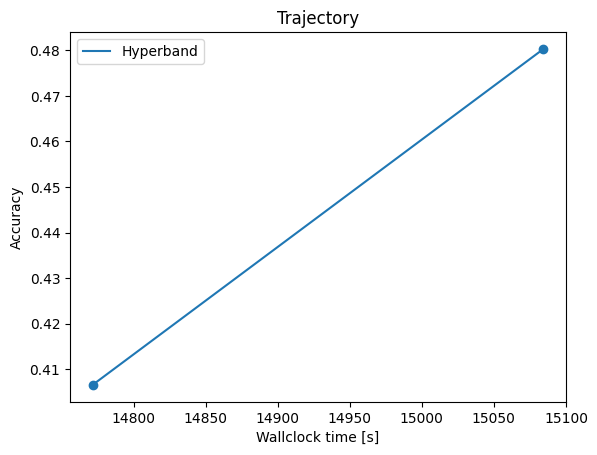

Timer unit: 1e-09 s

Total time: 15909.7 s
File: /var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_43860/306258932.py
Function: main at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def main():
     5                                           
     6                                               
     7         1    2072000.0    2e+06      0.0      CNN32 = CNN32Wrapper()
     8                                           
     9         1          0.0      0.0      0.0      facades: list[AbstractFacade] = []
    10         2       2000.0   1000.0      0.0      for intensifier_object in [Hyperband]:
    11                                                   # Define our environment variables
    12                                                   
    13         2      30000.0  15000.0      0.0          scenario = Scenario(
    14         1    1506000.0    2e+06      0.0              CNN32.configspace,
    1

In [13]:
from line_profiler import LineProfiler
from pathlib import Path
# @timeout(21600)
def main():

    
    CNN32 = CNN32Wrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:
        # Define our environment variables
        
        scenario = Scenario(
            CNN32.configspace,
            walltime_limit=21600,  # After 3600 seconds, we stop the hyperparameter optimization
            output_directory=Path("smac_hyperband_output_budget_6hr_CNN_2l"),
            n_trials=10000,  # Evaluate max 500 different trials
            min_budget=100,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
            # max_budget=25,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
            max_budget=1000,  # only for CNN32_5layers, Resnet18
            n_workers=2,
        )


        
        # We want to run five random configurations before starting the optimization.
        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        
        # Create our intensifier
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")
        
        # Create our SMAC object and pass the scenario and the train method
        smac = MFFacade(
            scenario,
            CNN32.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )
        # print("I fitted!!!!!!!!!!!!!!:", smac)

        # Let's optimize
        print("optimizing...")
        print(type(smac), "|", smac)
        opt_start_time = time.time()
        incumbent = smac.optimize()
        opt_end_time = time.time()
        print(f"opt execution time: {opt_end_time - opt_start_time} seconds")
        print("incumbent:", incumbent)
        # break
        # Get cost of default configuration
        default_cost = smac.validate(CNN32.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")

        # Let's calculate the cost of the incumbent
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")
        print("appending...")
        facades.append(smac)
        for attr in dir(smac):
            if not attr.startswith('__'):
                print(attr, getattr(smac, attr))
    print("attempting to plot")
    # Let's plot it
    print("facades:", facades)
    # BO_file = "CNN32_5l_BO_results_2h.txt"
    plot_trajectory(facades)

if __name__ == "__main__":
    with open('smac_results_2h.txt', "w") as f:
        pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

In [14]:
class CNN32Wrapper(BaseEstimator):
    def __init__(self, criterion = nn.CrossEntropyLoss()):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = cnn32_5l.to(self.device)
        self.criterion = criterion
        self.lr = None
        self.batch_size = None
        self.epochs = None
        self.optimizer = None

    @property
    def configspace(self)-> ConfigurationSpace:
        cs = ConfigurationSpace()
        lr_init = Float("lr_init", (0.00001, 0.1), log=True)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        solver = Categorical("solver", ["sgd", "adam"])
        batch_size = Integer("batch_size", (16, 1024))
        epochs = Integer("epochs", (30, 160))
        cs.add_hyperparameters([lr_init, learning_rate, solver, batch_size, epochs])

        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        cs.add_conditions([use_lr])

        weight_decay = Float("weight_decay", (0.0001, 0.1), log=True)
        momentum = Float("momentum", (0, 0.99))
        dampening = Float("dampening", (0, 0.99))
        cs.add_hyperparameters([weight_decay, momentum, dampening])

        weight_decay_condition = InCondition(child=weight_decay, parent=solver, values=["sgd", "adam"])
        momentum_condition = InCondition(child=momentum, parent=solver, values=["sgd"])
        dampening_condition = InCondition(child=dampening, parent=solver, values=["sgd"])
        cs.add_conditions([use_lr, weight_decay_condition, momentum_condition, dampening_condition])

        return cs
    
    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        self.trial_start_time = time.perf_counter()

        print("Config:", config)
        # print(time.time())
        epoch_start_timer = time.perf_counter()
        # print("okay here?")
        max_epochs = [0]
        # print("what abt here?")

        X = torch.tensor(train_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        y = torch.tensor(train_y, dtype=torch.long)
        valid_x_inFit = torch.tensor(valid_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        valid_y_inFit = torch.tensor(valid_y, dtype=torch.long)


        # ### only for resnet:
        # X = X.repeat(1, 3, 1, 1)
        # valid_x_inFit = valid_x_inFit.repeat(1, 3, 1, 1)


        # print("so far so good")
        # print("Model:", self.model)
        model = self.model
        # print("break1")
        # print("Criterion:", self.criterion)
        criterion = self.criterion

        self.lr = config.get('lr_init')
        # print("lr:", self.lr)
        self.epochs = config.get('epochs')
        # print("epochs:", self.epochs)
        self.batch_size = config.get('batch_size')
        # print("batch_size:", self.batch_size)
        # print("solver type:", type(self.sovler))
        solver_name = config.get('solver', 'sgd')
        # print("solver_name:", solver_name, type(solver_name))
        momentum = config.get('momentum', 0.9)
        weight_decay = config.get('weight_decay', 0.9)
        dampening = config.get('dampening', 0.9)
        print("is sgd:", solver_name=='sgd', "| is adam:", solver_name=='adam')
        # print(self.model.parameters())
        if solver_name == 'sgd':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'momentum': config.get('momentum', 0),
            #     'weight_decay': config.get('weight_decay', 0),
            #     'dampening': config.get('dampening', 0)
            # }
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)

        elif solver_name == 'adam':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'weight_decay': config.get('weight_decay', 0) 
            # }
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)

        else:
            raise ValueError(f"Unknown optimizer: {solver_name}")
        # print("solver type:", type(self.optimizer))
        # print("solver:", self.optimizer)
        prev_loss = float("inf")
        flag = 0

        for epoch in range(self.epochs):
            model.train()
            for i in range(0, len(X), self.batch_size):
                # print(type(X), type(y))
                inputs = X[i : i + self.batch_size].to(self.device)
                labels = y[i : i + self.batch_size].to(self.device)
                self.optimizer.zero_grad()
                if inputs.shape[0] <= 2:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

            model.eval()
            cur_loss = 0
            with torch.no_grad():
                for i in range(0, len(valid_x_inFit), self.batch_size):
                    # get the inputs
                    inputs = valid_x_inFit[i : i + self.batch_size].to(self.device)
                    labels = valid_y_inFit[i : i + self.batch_size].to(self.device)
                    if inputs.shape[0] == 1:
                        inputs = torch.cat((inputs, inputs, inputs), dim = 0)
                        labels = torch.cat((labels, labels, labels), dim = 0)

                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss
            # early stop if 3 epochs in a row no loss decrease
            # print(round(time.time()-epoch_start_timer, 2))
            # if time.perf_counter() - epoch_start_timer > budget:
            #     print(f"Stopping training early at epoch {epoch} due to time budget.")
            #     break  # Stop training if budget exceeded
            
            if cur_loss < prev_loss:
                prev_loss = cur_loss
                flag = 0
            else:
                flag += 1
                if flag >= 3:
                    max_epochs.append(epoch)
                    break

        # print(np.max(max_epochs))
        print("evaluating...")
        model.eval()
        with torch.no_grad():
            outputs = model(valid_x_inFit.to(self.device))
            _, predicted = torch.max(outputs.data, 1)
            predictions = predicted.cpu().numpy()
        acc = accuracy_score(valid_y, predictions)
        print("accuracy:", acc)

        self.trial_end_time = time.perf_counter()
        valid_probs = self.predict_proba(valid_x_inFit)
        valid_kappa = cohen_kappa_score(valid_y, predictions)
        valid_ece = get_ece(valid_probs, predictions, valid_y)
        with open('smac_results_2h.txt', "a") as f:
            f.write(f"Valid Accuracy: {acc}, Valid Kappa: {valid_kappa}, Valid ECE: {valid_ece}, Time: {self.trial_end_time - self.trial_start_time}\n")
            
        return 1-acc
    
    def predict_proba(self, X):
        # X = X.reshape(-1, 3, 32, 32)
        model = self.model
        model.eval()
        test_probs = []
        with torch.no_grad():
            outputs = model(X.to(self.device))
            test_prob = nn.Softmax(dim=1)(outputs)
            test_probs = test_prob.cpu().numpy()
            return test_probs
        
def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)
    # print("\nfacades[1]:", facades[1].scenario)
    # plt.ylim(0, 0.4)

    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()



[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimizing...
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fcef01229a0>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 

2024-05-12 19:54:32,302 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.62 GiB -- Worker memory limit: 8.00 GiB


accuracy: 0.2256


2024-05-12 19:55:21,599 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.61 GiB -- Worker memory limit: 8.00 GiB


opt execution time: 19391.64567923546 seconds
incumbent: None
Config: Configuration(values={
  'batch_size': 520,
  'dampening': 0.495,
  'epochs': 75,
  'learning_rate': 'constant',
  'lr_init': 0.01,
  'momentum': 0.495,
  'solver': 'sgd',
  'weight_decay': 0.0031622777,
})

is sgd: True | is adam: False
evaluating...
accuracy: 0.16253333333333334
Default cost (Hyperband): 0.8374666666666667
Config: None
Incumbent cost (Hyperband): inf
appending...
_acquisition_function <smac.acquisition.function.expected_improvement.EI object at 0x7fd7b17f8eb0>
_acquisition_maximizer <smac.acquisition.maximizer.local_and_random_search.LocalAndSortedRandomSearch object at 0x7fcef01228e0>
_callbacks []
_config_selector <smac.main.config_selector.ConfigSelector object at 0x7fcef01226d0>
_get_optimizer <bound method AbstractFacade._get_optimizer of <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fcef01229a0>>
_get_signature_arguments <bound method AbstractFacade._get_signature_argume

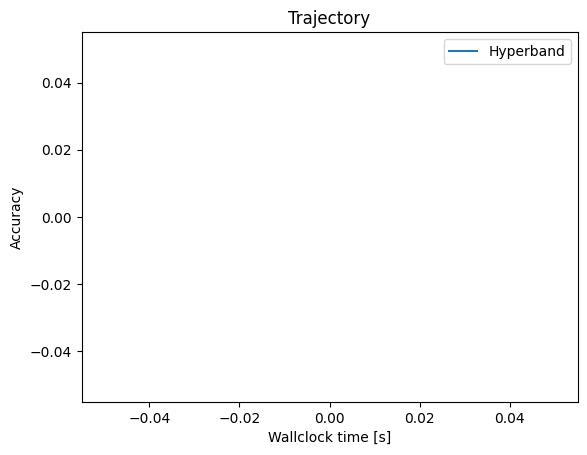

Timer unit: 1e-09 s

Total time: 19712.5 s
File: /var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_43860/3540217503.py
Function: main at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def main():
     5                                           
     6                                               
     7         1    3162000.0    3e+06      0.0      CNN32 = CNN32Wrapper()
     8                                           
     9         1          0.0      0.0      0.0      facades: list[AbstractFacade] = []
    10         2       2000.0   1000.0      0.0      for intensifier_object in [Hyperband]:
    11                                                   # Define our environment variables
    12                                                   
    13         2      28000.0  14000.0      0.0          scenario = Scenario(
    14         1    1025000.0    1e+06      0.0              CNN32.configspace,
    

In [15]:
from line_profiler import LineProfiler
from pathlib import Path
# @timeout(21600)
def main():

    
    CNN32 = CNN32Wrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:
        # Define our environment variables
        
        scenario = Scenario(
            CNN32.configspace,
            walltime_limit=21600,  # After 3600 seconds, we stop the hyperparameter optimization
            output_directory=Path("smac_hyperband_output_budget_6hr_CNN_5l"),
            n_trials=10000,  # Evaluate max 500 different trials
            min_budget=100,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
            # max_budget=25,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
            max_budget=1000,  # only for CNN32_5layers, Resnet18
            n_workers=2,
        )


        
        # We want to run five random configurations before starting the optimization.
        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        
        # Create our intensifier
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")
        
        # Create our SMAC object and pass the scenario and the train method
        smac = MFFacade(
            scenario,
            CNN32.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )
        # print("I fitted!!!!!!!!!!!!!!:", smac)

        # Let's optimize
        print("optimizing...")
        print(type(smac), "|", smac)
        opt_start_time = time.time()
        incumbent = smac.optimize()
        opt_end_time = time.time()
        print(f"opt execution time: {opt_end_time - opt_start_time} seconds")
        print("incumbent:", incumbent)
        # break
        # Get cost of default configuration
        default_cost = smac.validate(CNN32.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")

        # Let's calculate the cost of the incumbent
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")
        print("appending...")
        facades.append(smac)
        for attr in dir(smac):
            if not attr.startswith('__'):
                print(attr, getattr(smac, attr))
    print("attempting to plot")
    # Let's plot it
    print("facades:", facades)
    # BO_file = "CNN32_5l_BO_results_2h.txt"
    plot_trajectory(facades)

if __name__ == "__main__":
    with open('smac_results_2h.txt', "w") as f:
        pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

In [16]:
class CNN32Wrapper(BaseEstimator):
    def __init__(self, criterion = nn.CrossEntropyLoss()):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = resnet.to(self.device)
        self.criterion = criterion
        self.lr = None
        self.batch_size = None
        self.epochs = None
        self.optimizer = None

    @property
    def configspace(self)-> ConfigurationSpace:
        cs = ConfigurationSpace()
        lr_init = Float("lr_init", (0.00001, 0.1), log=True)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        solver = Categorical("solver", ["sgd", "adam"])
        batch_size = Integer("batch_size", (16, 1024))
        epochs = Integer("epochs", (30, 160))
        cs.add_hyperparameters([lr_init, learning_rate, solver, batch_size, epochs])

        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        cs.add_conditions([use_lr])

        weight_decay = Float("weight_decay", (0.0001, 0.1), log=True)
        momentum = Float("momentum", (0, 0.99))
        dampening = Float("dampening", (0, 0.99))
        cs.add_hyperparameters([weight_decay, momentum, dampening])

        weight_decay_condition = InCondition(child=weight_decay, parent=solver, values=["sgd", "adam"])
        momentum_condition = InCondition(child=momentum, parent=solver, values=["sgd"])
        dampening_condition = InCondition(child=dampening, parent=solver, values=["sgd"])
        cs.add_conditions([use_lr, weight_decay_condition, momentum_condition, dampening_condition])

        return cs
    
    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        self.trial_start_time = time.perf_counter()

        print("Config:", config)
        # print(time.time())
        epoch_start_timer = time.perf_counter()
        # print("okay here?")
        max_epochs = [0]
        # print("what abt here?")

        X = torch.tensor(train_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        y = torch.tensor(train_y, dtype=torch.long)
        valid_x_inFit = torch.tensor(valid_x.reshape(-1, 3, 32, 32), dtype=torch.float32)
        valid_y_inFit = torch.tensor(valid_y, dtype=torch.long)


        # ### only for resnet:
        # X = X.repeat(1, 3, 1, 1)
        # valid_x_inFit = valid_x_inFit.repeat(1, 3, 1, 1)


        # print("so far so good")
        # print("Model:", self.model)
        model = self.model
        # print("break1")
        # print("Criterion:", self.criterion)
        criterion = self.criterion

        self.lr = config.get('lr_init')
        # print("lr:", self.lr)
        self.epochs = config.get('epochs')
        # print("epochs:", self.epochs)
        self.batch_size = config.get('batch_size')
        # print("batch_size:", self.batch_size)
        # print("solver type:", type(self.sovler))
        solver_name = config.get('solver', 'sgd')
        # print("solver_name:", solver_name, type(solver_name))
        momentum = config.get('momentum', 0.9)
        weight_decay = config.get('weight_decay', 0.9)
        dampening = config.get('dampening', 0.9)
        print("is sgd:", solver_name=='sgd', "| is adam:", solver_name=='adam')
        # print(self.model.parameters())
        if solver_name == 'sgd':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'momentum': config.get('momentum', 0),
            #     'weight_decay': config.get('weight_decay', 0),
            #     'dampening': config.get('dampening', 0)
            # }
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)

        elif solver_name == 'adam':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'weight_decay': config.get('weight_decay', 0) 
            # }
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)

        else:
            raise ValueError(f"Unknown optimizer: {solver_name}")
        # print("solver type:", type(self.optimizer))
        # print("solver:", self.optimizer)
        prev_loss = float("inf")
        flag = 0

        for epoch in range(self.epochs):
            model.train()
            for i in range(0, len(X), self.batch_size):
                # print(type(X), type(y))
                inputs = X[i : i + self.batch_size].to(self.device)
                labels = y[i : i + self.batch_size].to(self.device)
                self.optimizer.zero_grad()
                if inputs.shape[0] <= 2:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

            model.eval()
            cur_loss = 0
            with torch.no_grad():
                for i in range(0, len(valid_x_inFit), self.batch_size):
                    # get the inputs
                    inputs = valid_x_inFit[i : i + self.batch_size].to(self.device)
                    labels = valid_y_inFit[i : i + self.batch_size].to(self.device)
                    if inputs.shape[0] == 1:
                        inputs = torch.cat((inputs, inputs, inputs), dim = 0)
                        labels = torch.cat((labels, labels, labels), dim = 0)

                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss
            # early stop if 3 epochs in a row no loss decrease
            # print(round(time.time()-epoch_start_timer, 2))
            # if time.perf_counter() - epoch_start_timer > budget:
            #     print(f"Stopping training early at epoch {epoch} due to time budget.")
            #     break  # Stop training if budget exceeded
            
            if cur_loss < prev_loss:
                prev_loss = cur_loss
                flag = 0
            else:
                flag += 1
                if flag >= 3:
                    max_epochs.append(epoch)
                    break

        # print(np.max(max_epochs))
        print("evaluating...")
        model.eval()
        with torch.no_grad():
            outputs = model(valid_x_inFit.to(self.device))
            _, predicted = torch.max(outputs.data, 1)
            predictions = predicted.cpu().numpy()
        acc = accuracy_score(valid_y, predictions)
        print("accuracy:", acc)

        self.trial_end_time = time.perf_counter()
        valid_probs = self.predict_proba(valid_x_inFit)
        valid_kappa = cohen_kappa_score(valid_y, predictions)
        valid_ece = get_ece(valid_probs, predictions, valid_y)
        with open('smac_results_2h.txt', "a") as f:
            f.write(f"Valid Accuracy: {acc}, Valid Kappa: {valid_kappa}, Valid ECE: {valid_ece}, Time: {self.trial_end_time - self.trial_start_time}\n")
            
        return 1-acc
    
    def predict_proba(self, X):
        # X = X.reshape(-1, 3, 32, 32)
        model = self.model
        model.eval()
        test_probs = []
        with torch.no_grad():
            outputs = model(X.to(self.device))
            test_prob = nn.Softmax(dim=1)(outputs)
            test_probs = test_prob.cpu().numpy()
            return test_probs
        
def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)
    # print("\nfacades[1]:", facades[1].scenario)
    # plt.ylim(0, 0.4)

    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()



[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimizing...
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fcff0609460>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 

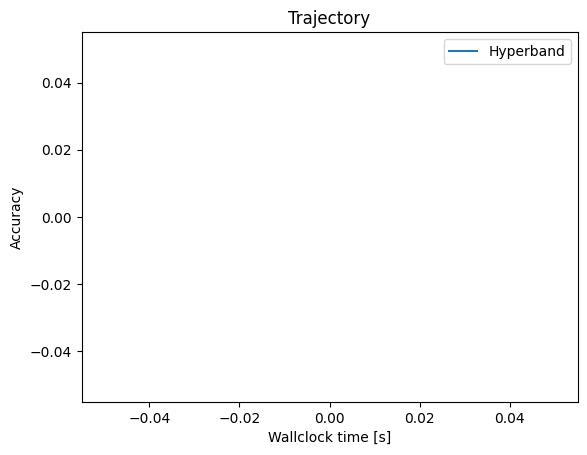

Timer unit: 1e-09 s

Total time: 35656.4 s
File: /var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_43860/1181825811.py
Function: main at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def main():
     5                                           
     6                                               
     7         1    3335000.0    3e+06      0.0      CNN32 = CNN32Wrapper()
     8                                           
     9         1          0.0      0.0      0.0      facades: list[AbstractFacade] = []
    10         2       3000.0   1500.0      0.0      for intensifier_object in [Hyperband]:
    11                                                   # Define our environment variables
    12                                                   
    13         2      34000.0  17000.0      0.0          scenario = Scenario(
    14         1    1461000.0    1e+06      0.0              CNN32.configspace,
    

In [17]:
from line_profiler import LineProfiler
from pathlib import Path
# @timeout(21600)
def main():

    
    CNN32 = CNN32Wrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:
        # Define our environment variables
        
        scenario = Scenario(
            CNN32.configspace,
            walltime_limit=21600,  # After 3600 seconds, we stop the hyperparameter optimization
            output_directory=Path("smac_hyperband_output_budget_6hr_Resnet"),
            n_trials=10000,  # Evaluate max 500 different trials
            min_budget=100,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
            # max_budget=25,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
            max_budget=1000,  # only for CNN32_5layers, Resnet18
            n_workers=2,
        )


        
        # We want to run five random configurations before starting the optimization.
        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        
        # Create our intensifier
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")
        
        # Create our SMAC object and pass the scenario and the train method
        smac = MFFacade(
            scenario,
            CNN32.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )
        # print("I fitted!!!!!!!!!!!!!!:", smac)

        # Let's optimize
        print("optimizing...")
        print(type(smac), "|", smac)
        opt_start_time = time.time()
        incumbent = smac.optimize()
        opt_end_time = time.time()
        print(f"opt execution time: {opt_end_time - opt_start_time} seconds")
        print("incumbent:", incumbent)
        # break
        # Get cost of default configuration
        default_cost = smac.validate(CNN32.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")

        # Let's calculate the cost of the incumbent
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")
        print("appending...")
        facades.append(smac)
        for attr in dir(smac):
            if not attr.startswith('__'):
                print(attr, getattr(smac, attr))
    print("attempting to plot")
    # Let's plot it
    print("facades:", facades)
    # BO_file = "CNN32_5l_BO_results_2h.txt"
    plot_trajectory(facades)

if __name__ == "__main__":
    with open('smac_results_2h.txt', "w") as f:
        pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

In [3]:
runhistory_path = "smac_hyperband_output_budget_2hr_CNN_5l/3dfdef37a2c720217b5848e4da32ffe9/0/runhistory.json"

with open(runhistory_path, "r") as file:
    runhistory_data_CNN = json.load(file)

print("Length of runhistory_data_CNN:", len(runhistory_data_CNN["data"]))

configs_costs_CNN = []
for entry in runhistory_data_CNN["data"]:
    # print(entry)
    config_id = entry[0]  
    cost = entry[4]  
    configs_costs_CNN.append((entry[0], entry[4]))
    configs_costs_CNN = list(set(configs_costs_CNN))

    # print(f"Config ID: {config_id}, Cost: {cost}")
    if config_id == 44:# or config_id == 21:
        params_CNN = runhistory_data_CNN["configs"][str(config_id)]
        # print(entry)
        print(f"CNN config ID: {config_id}, Cost: {cost}, Parameters: {params_CNN}\n")


min_cost_config_CNN = []
min_cost_config_CNN = sorted(configs_costs_CNN, key=lambda x: x[1])[:5]
print("CNN min 5:")
for config_id, cost in min_cost_config_CNN:
    
    params = runhistory_data_CNN["configs"][str(config_id)]
    print(f"Config ID: {config_id}, Cost: {cost}, Parameters: {params}\n")
file.close()


Length of runhistory_data_CNN: 9
CNN min 5:
Config ID: 3, Cost: 0.8436, Parameters: {'batch_size': 624, 'epochs': 111, 'lr_init': 0.013680095279726922, 'solver': 'adam', 'weight_decay': 0.0070925432147358365}

Config ID: 5, Cost: 0.848, Parameters: {'batch_size': 443, 'epochs': 64, 'lr_init': 0.0013869861245357324, 'solver': 'adam', 'weight_decay': 0.011103525577197588}

Config ID: 1, Cost: 0.8734666666666666, Parameters: {'batch_size': 569, 'epochs': 88, 'lr_init': 0.03832216850492789, 'solver': 'sgd', 'dampening': 0.9688321588104364, 'learning_rate': 'invscaling', 'momentum': 0.2619100559835807, 'weight_decay': 0.007126995609048582}

Config ID: 6, Cost: 0.8742666666666666, Parameters: {'batch_size': 378, 'epochs': 69, 'lr_init': 0.024846338168982397, 'solver': 'sgd', 'dampening': 0.660099048291211, 'learning_rate': 'adaptive', 'momentum': 0.2082787354631025, 'weight_decay': 0.00024365700014641997}

Config ID: 2, Cost: 0.8788666666666667, Parameters: {'batch_size': 737, 'epochs': 69, 

In [2]:
runhistory_path_RES = "smac_hyperband_output_budget_2hr_XGBT/cb99f55e09d035f575c5f944893086b6/0/runhistory.json"

with open(runhistory_path_RES, "r") as file:
    runhistory_data_RES = json.load(file)

print("Length of runhistory data:", len(runhistory_data_RES["data"]))

configs_costs_RES = []
for entry in runhistory_data_RES["data"]:
    config_id = entry[0]  
    cost = entry[4]
    configs_costs_RES.append((entry[0], entry[4]))
    configs_costs_RES = list(set(configs_costs_RES))
    if config_id == 44:
        params = runhistory_data_RES["configs"][str(config_id)]
        # print(entry)
        print(f"Resnet Config ID: {config_id}, Cost: {cost}, Parameters: {params}\n")


min_cost_config_RES = []
min_cost_config_RES = sorted(configs_costs_RES, key=lambda x: x[1])[:5]
print(type(min_cost_config_RES))
print("Resnet min 5:")
for config_id, cost in min_cost_config_RES:
    
    params = runhistory_data_RES["configs"][str(config_id)]
    print(f"Config ID: {config_id}, Cost: {cost}, Parameters: {params}\n")
file.close()

Length of runhistory data: 3
<class 'list'>
Resnet min 5:
Config ID: 2, Cost: 0.4538333333333334, Parameters: {'colsample_bylevel': 0.8006325564606935, 'colsample_bynode': 0.6063110478838847, 'colsample_bytree': 0.6702264438270331, 'gamma': 0.11819655769629316, 'learning_rate': 0.24175598362284983, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 773, 'subsample': 0.7185159768996707}

Config ID: 3, Cost: 0.4995666666666667, Parameters: {'colsample_bylevel': 0.7219343632501507, 'colsample_bynode': 0.9242411005474558, 'colsample_bytree': 0.6976311927657526, 'gamma': 0.8493578609931441, 'learning_rate': 0.14382901505335025, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 779, 'subsample': 0.8488155979636325}

Config ID: 1, Cost: 0.5049666666666667, Parameters: {'colsample_bylevel': 0.6841694527491273, 'colsample_bynode': 0.7521258791466592, 'colsample_bytree': 0.8542075266578653, 'gamma': 0.17841636973138664, 'learning_rate': 0.2937993192475016, 'max_depth': 14, 'min_child_w

In [28]:
test_res = []
test_cnn = []
params_RES = runhistory_data_RES["configs"]
params_CNN = runhistory_data_CNN["configs"]

print(f"length of Res:{len(params_RES)}")
print(f"length of CNN:{len(params_CNN)}")

cnt = 0
i_list = []
for i in range(1, 200):
    try:
        res_params = runhistory_data_RES["configs"][str(i)]
        cnn_params = runhistory_data_CNN["configs"][str(i)]
        print("ID = {}, match_status = {} \n".format(i, res_params == cnn_params))
        if res_params != cnn_params:
            i_list.append(i)
            cnt += 1
        # print(res_params, cnn_params, "\n")
    except KeyError:
        print("KeyError: skipping entry")

print(f"{cnt} pairs not same")
print(f"first difference occured at {min(i_list)}")


length of Res:57
length of CNN:55
ID = 1, match_status = True 

ID = 2, match_status = True 

ID = 3, match_status = True 

ID = 4, match_status = True 

ID = 5, match_status = True 

ID = 6, match_status = True 

ID = 7, match_status = True 

ID = 8, match_status = True 

ID = 9, match_status = True 

ID = 10, match_status = False 

ID = 11, match_status = False 

ID = 12, match_status = False 

ID = 13, match_status = False 

ID = 14, match_status = False 

ID = 15, match_status = False 

ID = 16, match_status = False 

ID = 17, match_status = False 

ID = 18, match_status = True 

ID = 19, match_status = True 

ID = 20, match_status = True 

ID = 21, match_status = True 

ID = 22, match_status = True 

ID = 23, match_status = True 

ID = 24, match_status = True 

ID = 25, match_status = True 

ID = 26, match_status = True 

ID = 27, match_status = True 

ID = 28, match_status = True 

ID = 29, match_status = True 

ID = 30, match_status = True 

ID = 31, match_status = True 

ID = 3